# Overview

This notebook is created for training purposes only. Dataset comes from https://www.kaggle.com/kartik2112/fraud-detection

Note - according to Kaggle, this simulated data and does not include actual credit card numbers ,names, and transactions. Just to be safe, will drop first name, last name, and cc_num field from import data

# Import and General Analysis

In [1]:
#import data and review top 10 rows

import pandas as pd
import numpy as np

df = pd.read_csv('C:/fraudTrain.csv')

df = df.drop(['cc_num', 'first', 'last'], axis=1)

df.head()

,Unnamed: 0,trans_date_trans_time,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [2]:
#examine dataset size
df.shape

(1296675, 20)

In [3]:
#identify any missing values
print(df.isna().sum())

Unnamed: 0               0
trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [4]:
#explore datatypes to fix

df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
merchant                  object
category                  object
amt                      float64
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [5]:
#drop 'Unamed : 0' since this is just index repeated

df = df.drop('Unnamed: 0', axis =1)

#change dtypes

df['zip'] = df['zip'].astype('str')


In [6]:
print(df['is_fraud'].value_counts())

0    1289169
1       7506
Name: is_fraud, dtype: int64


We have a clear class imbalance for our target variable..will need to keep this in mind as we create our models

# Visual and Statistical Analysis for Features

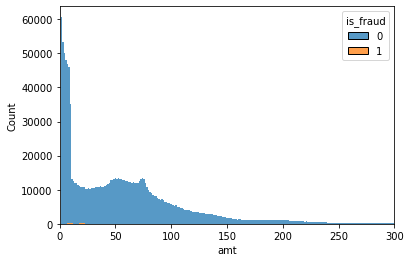

In [7]:
#examine the amt field
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.histplot(data=df, x='amt', ax=ax, hue='is_fraud',  multiple="stack")
ax.set_xlim(0,300)   #set because most transactions are under 300
plt.show()

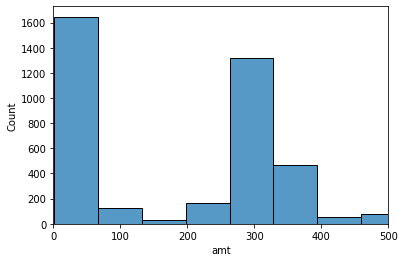

In [8]:
#examine field for just fraud transactions
import matplotlib.pyplot as plt
import seaborn as sns

fraud_trans = df[df['is_fraud'] == 1].reset_index()

fig, ax = plt.subplots()
sns.histplot(data=fraud_trans, x='amt', ax=ax)
ax.set_xlim(0,500) 
plt.show()

Looks like amts over 200 may be a predictor of fraud based on the 2 charts above

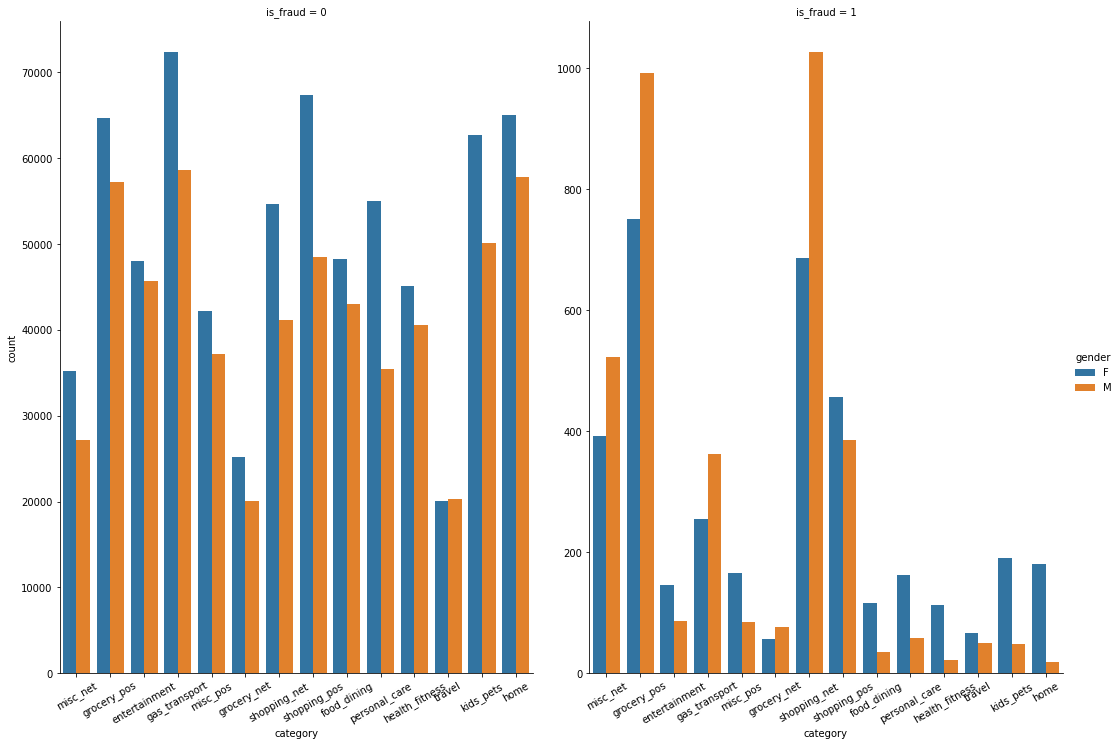

In [9]:
#examine category for both fraud non fraud transactions, color by gender

ax = sns.catplot(x="category", col="is_fraud",
                data=df, kind="count", hue = 'gender',
                height=10, aspect=.75, sharey=False)

ax.set_xticklabels(rotation = 30)


appears grocery and shopping are associated with more fraud..also interesting that males appear to have more fraud

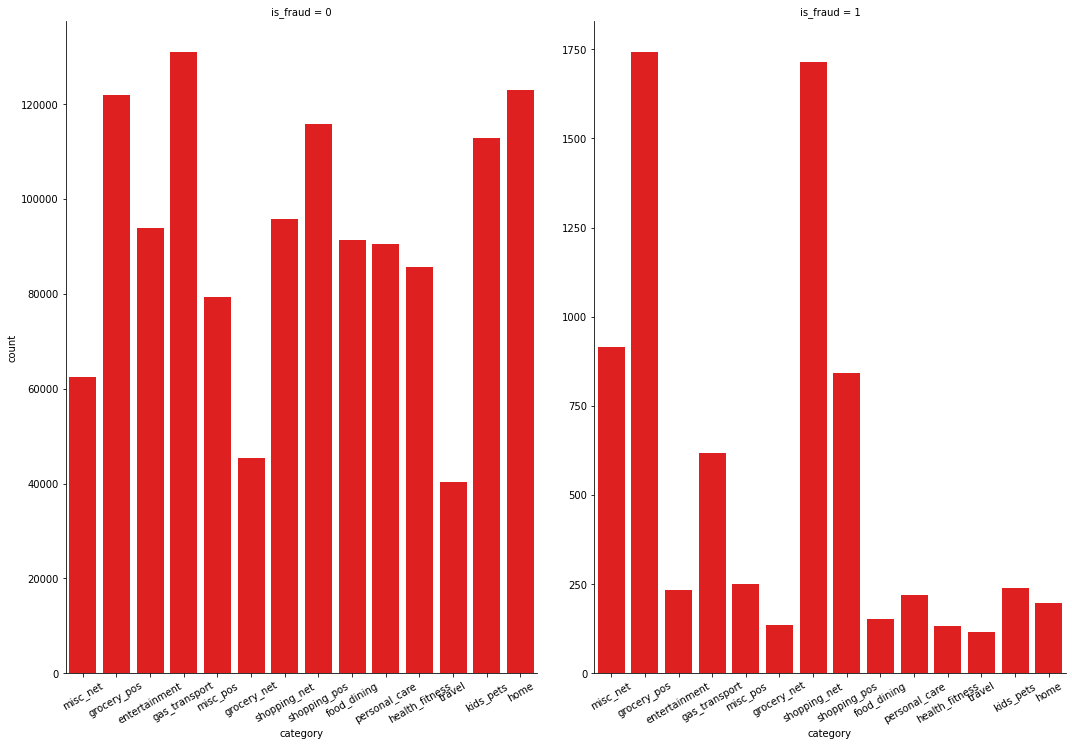

In [10]:
#examine categories without the gender for hue

ax = sns.catplot(x="category", col="is_fraud",
                data=df, kind="count",
                height=10, aspect=.75, sharey=False, color='red')

ax.set_xticklabels(rotation = 30)

Categories appear to be different for fraud cases..will one hot encode this category for model creation or flag just the grocery transactions

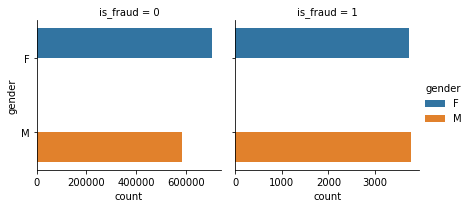

In [11]:
#examine overall disbursement of male/female for non vs fraud

ax = sns.catplot(y="gender", col="is_fraud",
                data=df, kind="count", hue = 'gender',
                height=3, aspect=1, sharex=False)



So Male transactions are slightly higher but will need to examine further with chi square analysis

In [12]:
#chi square analysis to see if any categorical features have predictive power
from scipy import stats

crosstab = pd.crosstab(df['gender'], df['is_fraud'])
print(crosstab)
stats.chi2_contingency(crosstab)

is_fraud       0     1
gender                
F         706128  3735
M         583041  3771


(75.51456622055794,
 3.627211385830374e-18,
 1,
 array([[705753.85030713,   4109.14969287],
        [583415.14969287,   3396.85030713]]))

since the p-value from the chi square is less than 0.5, we can assume Gender does have predictive power for determining fraud in order date

In [13]:
#convert transaction date/time to datetime format and extract hour and weekday from transaction date
from datetime import datetime as date
df['trans_date_trans_time'] = df['trans_date_trans_time'].astype('datetime64[ns]')

df['hour'] = df['trans_date_trans_time'].dt.hour
df['weekday'] = df['trans_date_trans_time'].dt.strftime("%A")

In [14]:
df.head()

,trans_date_trans_time,merchant,category,amt,gender,street,city,state,zip,lat,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,weekday
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday


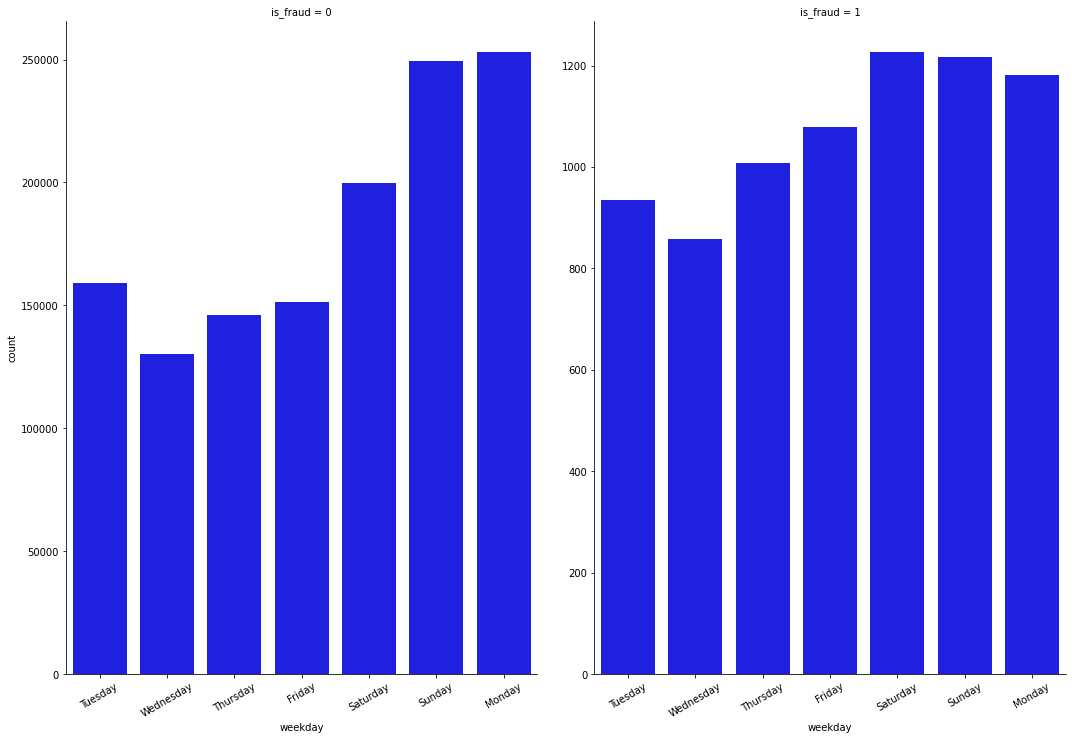

In [14]:
#examine weekday for both fraud non fraud transactions

ax = sns.catplot(x="weekday", col="is_fraud",
                data=df, kind="count",
                height=10, aspect=.75, sharey=False, color='blue')

ax.set_xticklabels(rotation = 30)

Appears saturdays might have a higher incidence of fraud when compared to overall. Examine with a chi-square analysis

In [15]:
#chi square for saturday fraud

def weekday(x):
    if x == 'Saturday':
        return 1
    else:
        return 0

df['Saturday'] = df['weekday'].apply(weekday)

crosstab = pd.crosstab(df['Saturday'], df['is_fraud'])
print(crosstab)
stats.chi2_contingency(crosstab)

is_fraud        0     1
Saturday               
0         1089439  6279
1          199730  1227


(4.090893867017753,
 0.04311483511067811,
 1,
 array([[1089375.2700885,    6342.7299115],
        [ 199793.7299115,    1163.2700885]]))

It does appear we Saturday has predictive power for fraud..will include in model creation

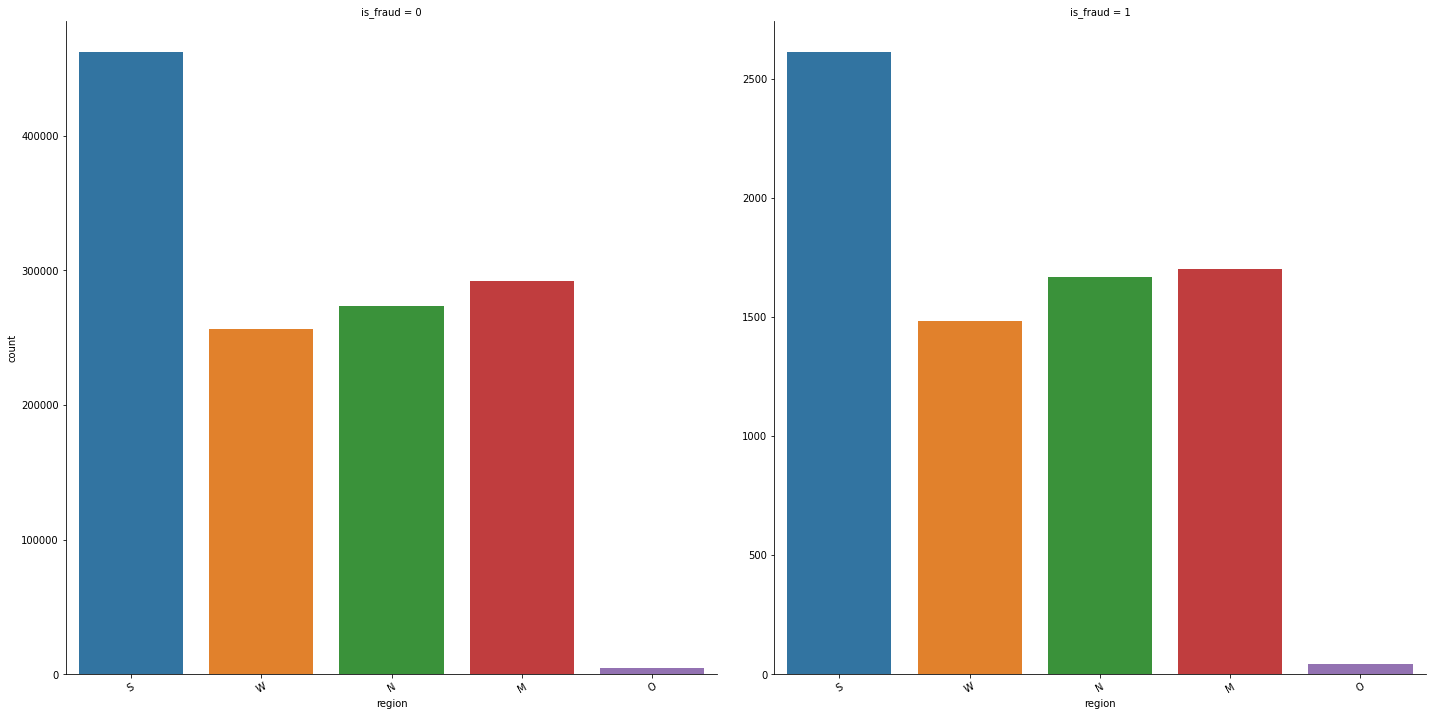

In [16]:
#examine states

#map states to region. Python dictionary mapping two letter state abbreviations to their respective regions of the country (i.e. Midwest, North East, etc.) N - North East W - West M - Mid West S - South O - Other

states = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

df['region']= df['state'].map(states)

ax = sns.catplot(x="region", col="is_fraud",
                data=df, kind="count",
                height=10, aspect=1, sharey=False)

ax.set_xticklabels(rotation = 30)

pretty equal disbursments by region

<AxesSubplot:>

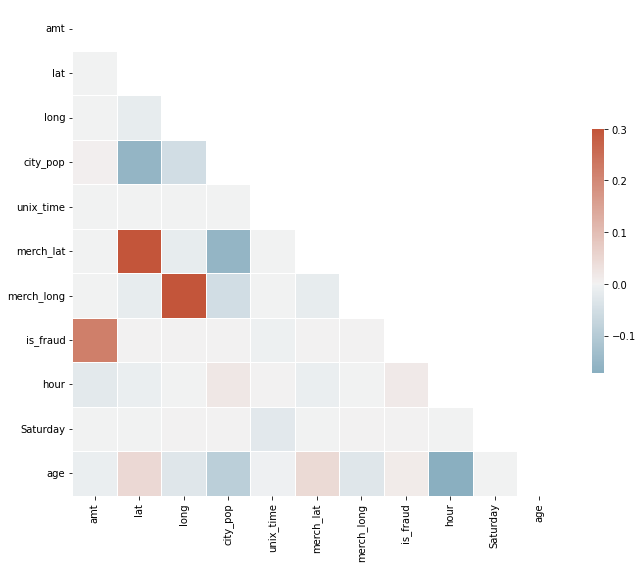

In [17]:
#show a correlation matrix, and add age client
import matplotlib.pyplot as plt
from datetime import timedelta
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')
df['age'] = (date.today() - df['dob']) // timedelta(days=365.2425)

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

no strong correlations with the target variable. slight correlation with the amt. Also good to know there is no colinearity to be aware of

<AxesSubplot:>

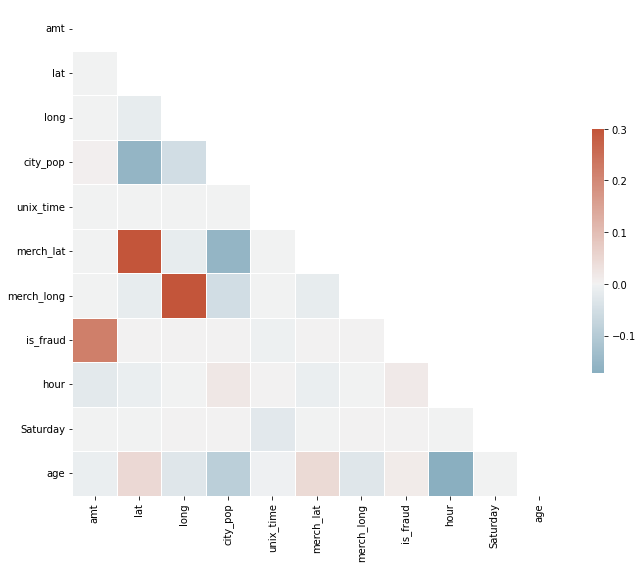

In [18]:
#examine just fraud transactions for correlations


fraud_trans['dob'] = pd.to_datetime(fraud_trans['dob'], format='%Y-%m-%d')
fraud_trans['age'] = (date.today() - fraud_trans['dob']) // timedelta(days=365.2425)

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


(array([ 486., 1047., 1014.,  995., 1202., 1049.,  634.,  414.,  392.,
         273.]),
 array([17. , 24.9, 32.8, 40.7, 48.6, 56.5, 64.4, 72.3, 80.2, 88.1, 96. ]),
 <BarContainer object of 10 artists>)

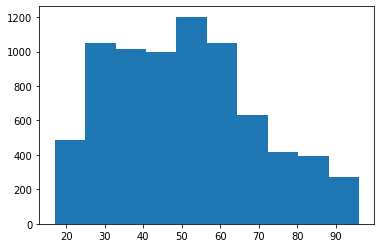

In [19]:
plt.hist(fraud_trans['age'])

(array([ 83820., 173108., 245168., 229856., 203503., 125014., 107165.,
         56448.,  39158.,  33435.]),
 array([17., 25., 33., 41., 49., 57., 65., 73., 81., 89., 97.]),
 <BarContainer object of 10 artists>)

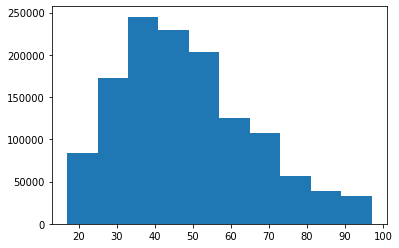

In [20]:
plt.hist(df['age'])

Appears age is something that can bucketed further for the model..50-60 years old appears to be associated with higher fraud. examine hour of transaction further

(array([1918.,  655.,  100.,  152.,   82.,  147.,  241.,  159.,  143.,
        3909.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

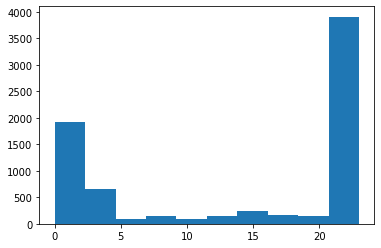

In [21]:
fraud_trans['trans_date_trans_time'] = fraud_trans['trans_date_trans_time'].astype('datetime64[ns]')

fraud_trans['hour'] = fraud_trans['trans_date_trans_time'].dt.hour
plt.hist(fraud_trans['hour'])

(array([128027.,  84632.,  84471., 126893.,  84353., 130571., 196002.,
        131501., 130606., 199619.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

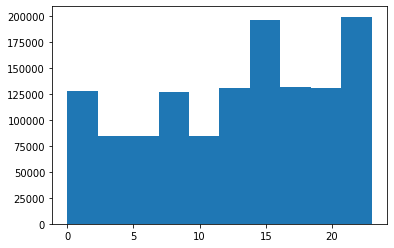

In [22]:
plt.hist(df['hour'])

appears fraud occurs between 10pm and 4 am more often

# Feature Engineering

Features to create - Amt > 200, Saturday field (1 for saturday, else 0- already completed), late hour field, age > 50 field. flag for grocery categories


In [23]:
#Create field for Amt>200 since this was identified as an indicator for fraud

def amt_200(x):
    if x > 200:
        return 1
    else:
        return 0

df['amt_200'] = df['amt'].apply(amt_200)


In [24]:
#create field to flag transactions that occur after 10 am and before 4 pm - increased volume of fraud

def after_hour_trans(x):
    if x > 19 & x < 5 :
        return 1
    else:
        return 0

df['after_hours'] = df['hour'].apply(after_hour_trans)


In [25]:
#create field to flag customer age > 50 - increased volume of fraud

def age_50(x):
    if x > 50 :
        return 1
    else:
        return 0

df['age_50'] = df['age'].apply(age_50)

In [30]:
#create field to flag categories of grocery_pos and grocery_net

def grocery(x):
    if x == 'grocery_pos' :
        return 1
    if x == 'grocery_net':
        return 1
    else:
        return 0

df['grocery_fl'] = df['category'].apply(grocery)

In [31]:
df.head()

,trans_date_trans_time,merchant,category,amt,gender,street,city,state,zip,lat,...,is_fraud,hour,weekday,Saturday,region,age,amt_200,after_hours,age_50,grocery_fl
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,...,0,0,Tuesday,0,S,34,0,0,0,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,...,0,0,Tuesday,0,W,43,0,0,0,1
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,...,0,0,Tuesday,0,W,60,1,0,1,0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,...,0,0,Tuesday,0,W,55,0,0,1,0
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,...,0,0,Tuesday,0,S,35,0,0,0,0


# Pipeline & More Feature Engineering

Feature Engineering for pipeline - Drop unused columns, Scale Amt field, One Hot Encode Gender/Category, SMOTE for unbalanced data

In [32]:
#remove columns
from sklearn.preprocessing import FunctionTransformer

def drop_cols(df,cols_to_drop):

    df_copy = df.copy()
    
    ret_df = df_copy.drop(columns=cols_to_drop)
    return ret_df

cols_to_drop = ['trans_date_trans_time', 'category', 'merchant', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 
               'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'hour', 'weekday', 'region', 'age']
drop_cols_trans = FunctionTransformer(drop_cols, kw_args={'cols_to_drop':cols_to_drop})


In [33]:
#encode categorical variables
cats = ['gender']
from sklearn.preprocessing import OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

In [34]:
#scale numerical fields

from sklearn.preprocessing import StandardScaler

numerical_feats = ['amt']
scaler = StandardScaler()

In [35]:
#create pipeline with SMOTE since we have a class imbalance for target variable is_fraud
#try pipeline with Logistic Regression Model First

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


preprocessor = ColumnTransformer(transformers=[
    ('scaler', scaler, numerical_feats),
    ("encoder", categorical_transformer, cats)],
    remainder='passthrough')



pipeline = imbpipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['model', LogisticRegression()]])

# Split Data

In [36]:
X= df.drop(['is_fraud'],axis=1)
y= df['is_fraud']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Logistic Regression

In [37]:

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

confusion Matrix is :nn [[369944  16783]
 [   521   1755]]
f1 score for base model is :  0.16863649466705102
roc_auc score for base model is : 0.9132793772274692
average precision score :  0.30632378085403955


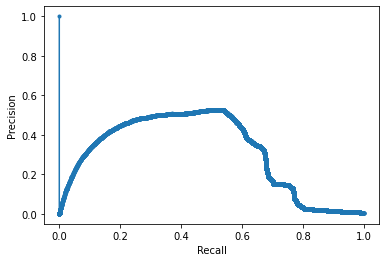

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    386727
           1       0.09      0.77      0.17      2276

    accuracy                           0.96    389003
   macro avg       0.55      0.86      0.57    389003
weighted avg       0.99      0.96      0.97    389003



In [38]:
# examine base model

y_pred_proba = pipeline.predict_proba(X_test)[:,1]

from sklearn.metrics import average_precision_score, precision_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix, f1_score, roc_auc_score
cm = confusion_matrix(y_test, y_pred)
print("confusion Matrix is :nn",cm)


print("f1 score for base model is : " , f1_score(y_test,y_pred))

print("roc_auc score for base model is :" , roc_auc_score(y_test, y_pred_proba))

#calculate average precision score which is the AUC for the precision recall curve
print("average precision score : ", average_precision_score(y_test, y_pred_proba))

precision, recall, th = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print(classification_report(y_test, y_pred))

Logistic Regression did an ok job of identifying fraudulent transactions but identified alot of false positives as evidenced by the poor precision for value of 1

# Random Forest

confusion Matrix is :nn [[378466   8261]
 [   590   1686]]
f1 score for base model is :  0.27587335351386727
roc_auc score for base model is : 0.9072284381634174
average precision score :  0.28436507556142226


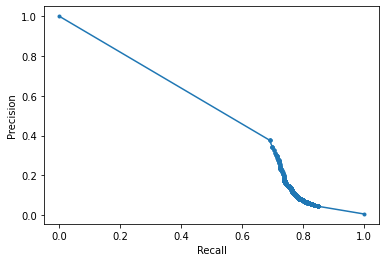

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    386727
           1       0.17      0.74      0.28      2276

    accuracy                           0.98    389003
   macro avg       0.58      0.86      0.63    389003
weighted avg       0.99      0.98      0.98    389003



In [39]:
from sklearn.ensemble import RandomForestClassifier


pipeline = imbpipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['model', RandomForestClassifier()]])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# examine model

y_pred_proba = pipeline.predict_proba(X_test)[:,1]


cm = confusion_matrix(y_test, y_pred)
print("confusion Matrix is :nn",cm)


print("f1 score for base model is : " , f1_score(y_test,y_pred))

print("roc_auc score for base model is :" , roc_auc_score(y_test, y_pred_proba))

#calculate average precision score which is the AUC for the precision recall curve
print("average precision score : ", average_precision_score(y_test, y_pred_proba))

precision, recall, th = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print(classification_report(y_test, y_pred))

Random Forest Improved overall but still has a low precision

# Gradient Boosting

confusion Matrix is :nn [[354847  31880]
 [   215   2061]]
f1 score for base model is :  0.1138139547726206
roc_auc score for base model is : 0.9760832895098732
average precision score :  0.6151355912831712


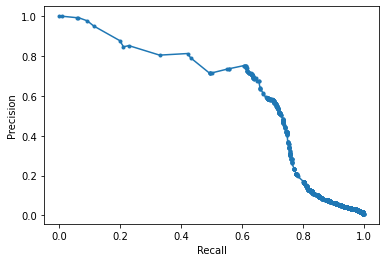

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    386727
           1       0.06      0.91      0.11      2276

    accuracy                           0.92    389003
   macro avg       0.53      0.91      0.54    389003
weighted avg       0.99      0.92      0.95    389003



In [40]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = imbpipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['model', GradientBoostingClassifier()]])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# examine model

y_pred_proba = pipeline.predict_proba(X_test)[:,1]


cm = confusion_matrix(y_test, y_pred)
print("confusion Matrix is :nn",cm)


print("f1 score for base model is : " , f1_score(y_test,y_pred))

print("roc_auc score for base model is :" , roc_auc_score(y_test, y_pred_proba))

#calculate average precision score which is the AUC for the precision recall curve
print("average precision score : ", average_precision_score(y_test, y_pred_proba))

precision, recall, th = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print(classification_report(y_test, y_pred))

Gradient Boosting did not perform as well out of the box compared to Random Forests but did have a particularly higher recall meaning it did better at identifying the true fraud transactions

# AdaBoost

confusion Matrix is :nn [[339875  46852]
 [   184   2092]]
f1 score for base model is :  0.08168684107770403
roc_auc score for base model is : 0.9677630466359464
average precision score :  0.526416942224283


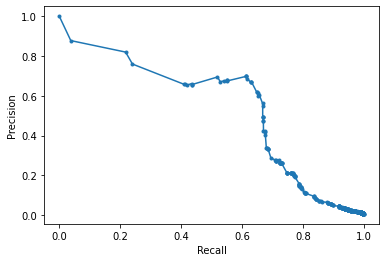

              precision    recall  f1-score   support

           0       1.00      0.88      0.94    386727
           1       0.04      0.92      0.08      2276

    accuracy                           0.88    389003
   macro avg       0.52      0.90      0.51    389003
weighted avg       0.99      0.88      0.93    389003



In [41]:
from sklearn.ensemble import AdaBoostClassifier

pipeline = imbpipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['model', AdaBoostClassifier()]])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# examine model

y_pred_proba = pipeline.predict_proba(X_test)[:,1]


cm = confusion_matrix(y_test, y_pred)
print("confusion Matrix is :nn",cm)


print("f1 score for base model is : " , f1_score(y_test,y_pred))

print("roc_auc score for base model is :" , roc_auc_score(y_test, y_pred_proba))

#calculate average precision score which is the AUC for the precision recall curve
print("average precision score : ", average_precision_score(y_test, y_pred_proba))

precision, recall, th = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print(classification_report(y_test, y_pred))

# Random Forest w/ Class Weight Balanced

confusion Matrix is :nn [[381274   5453]
 [  1010   1266]]
f1 score for base model is :  0.28148971650917176
roc_auc score for base model is : 0.8594965787025878
average precision score :  0.49495557121270345


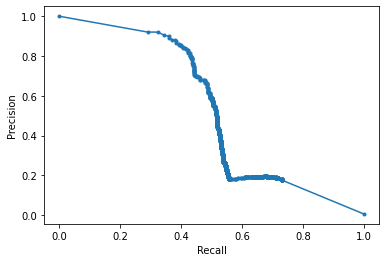

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    386727
           1       0.19      0.56      0.28      2276

    accuracy                           0.98    389003
   macro avg       0.59      0.77      0.64    389003
weighted avg       0.99      0.98      0.99    389003



In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['model', RandomForestClassifier(class_weight="balanced")]])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# examine model

y_pred_proba = pipeline.predict_proba(X_test)[:,1]


cm = confusion_matrix(y_test, y_pred)
print("confusion Matrix is :nn",cm)


print("f1 score for base model is : " , f1_score(y_test,y_pred))

print("roc_auc score for base model is :" , roc_auc_score(y_test, y_pred_proba))

#calculate average precision score which is the AUC for the precision recall curve
print("average precision score : ", average_precision_score(y_test, y_pred_proba))

precision, recall, th = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print(classification_report(y_test, y_pred))

Despite lower recall. overall F1 score better with Random Forest when class weight balaneced parameter set. This may be a better model to tune since we dont want to flag non-fraud purchases as fraudulent as this could cause customer impact. With that said, this would be a cost benefit analysis to consider at this point in a real life scenario

# Random Forest w/ Class Weight Balance Tuning

In [46]:
#hyperparameter tuning for Random Forest

from sklearn.model_selection import RandomizedSearchCV

pipeline = Pipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['model', RandomForestClassifier(class_weight="balanced")]])


params = {'model__n_estimators': [10,20,50, 60, 100, 150], 
'model__max_depth' : [2, 8, 15, 25],
'model__min_samples_leaf' :[1, 2, 4],
'model__min_samples_split' : [2, 5, 10] } 



search = RandomizedSearchCV(pipeline, params, n_iter=20, scoring='f1', n_jobs=-1)

result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)





Best Score: 0.3637473417959396
Best Hyperparameters: {'model__n_estimators': 10, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 25}


In [47]:
#hyperparaeter tuning with Grid search

from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['model', RandomForestClassifier(class_weight="balanced")]])

params = {'model__n_estimators': [10,15, 20], 
'model__max_depth' : [20, 25],
'model__min_samples_leaf' :[2, 4, 6] } 

grid_search_rf = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, cv=3, scoring='f1')
grid_search_rf.fit(X_train, y_train)

print('Best hyperparams: %s' % grid_search_rf.best_params_)
print('Best Score: %s' % grid_search_rf.best_score_)
print('Best estimator: %s' % grid_search_rf.best_estimator_)

Best hyperparams: {'model__max_depth': 25, 'model__min_samples_leaf': 4, 'model__n_estimators': 10}
Best Score: 0.38194828628643146
Best estimator: Pipeline(steps=[('drop_cols',
                 FunctionTransformer(func=<function drop_cols at 0x000001C60F8383A8>,
                                     kw_args={'cols_to_drop': ['trans_date_trans_time',
                                                               'category',
                                                               'merchant',
                                                               'street', 'city',
                                                               'state', 'zip',
                                                               'lat', 'long',
                                                               'city_pop',
                                                               'job', 'dob',
                                                               'trans_num',
                                

improved F-1 score to 38 percent. Not great but still an improvement. Create final model and asses on test data

# Final Model

confusion Matrix is :nn [[381501   5226]
 [   690   1586]]
f1 score for base model is :  0.34903169014084506
roc_auc score for base model is : 0.9028811919261328
average precision score :  0.6080816134551607


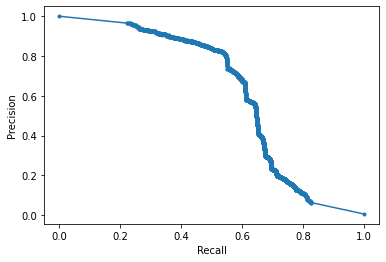

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    386727
           1       0.23      0.70      0.35      2276

    accuracy                           0.98    389003
   macro avg       0.62      0.84      0.67    389003
weighted avg       0.99      0.98      0.99    389003



In [48]:
pipeline = Pipeline(steps = [['drop_cols', drop_cols_trans],
                                ['preprocessor', preprocessor],
                                ['model', RandomForestClassifier(class_weight='balanced', max_depth=25,
                                        min_samples_leaf=4, n_estimators=10)]])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# examine model

y_pred_proba = pipeline.predict_proba(X_test)[:,1]


cm = confusion_matrix(y_test, y_pred)
print("confusion Matrix is :nn",cm)


print("f1 score for base model is : " , f1_score(y_test,y_pred))

print("roc_auc score for base model is :" , roc_auc_score(y_test, y_pred_proba))

#calculate average precision score which is the AUC for the precision recall curve
print("average precision score : ", average_precision_score(y_test, y_pred_proba))

precision, recall, th = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print(classification_report(y_test, y_pred))

Summary: We tried several different algorithims, Random Forest being the best out of the box. With parameter tuning, we were able to increase the f1 score from 28 to 35 percent. The final model still has alot of improvements to be made and decisions about the trade off between precision/recall will help shape future developments on this dataset

Future Considerations : Dimensonality Reduction, Explore other features, Hyperparameter tuning other algorithims, more hyper tuning for Random Forest, assesing financial impact of approving a fraud charge, tweaking precision/recall thresholds based on business strategy